<a href="https://colab.research.google.com/github/Raghuram-Veeramallu/Astro_Stat_Project2/blob/harry/Project2_Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 2
### Group 3


Project Question

In [1]:
# load data for this instance
# !gdown 1LZts3qmmXzULOUMvNC97jIE9funj_BoK

### New dataset downloaded by Hari
!gdown 1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0

Downloading...
From: https://drive.google.com/uc?id=1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0
To: /content/snaeT1.tsv
100% 47.4k/47.4k [00:00<00:00, 12.2MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import arviz as az

In [3]:
## setting the theme for the grid
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [4]:
# df = pd.read_csv('/content/SNLightCurveParams.csv')

df = pd.read_csv('/content/snaeT1.tsv', sep='\t')

In [5]:
df.sample(10)

,zcmb,zhel,mb,e_mb,x1,e_x1,c,e_c,logMst
712,0.031,0.0309,16.462,0.140,-1.343,0.042,-0.117,0.022,11.314
194,0.788,0.7900,23.976,0.096,1.396,0.212,-0.109,0.050,8.980
154,0.420,0.4190,22.938,0.088,-0.258,0.174,0.008,0.027,9.609
665,0.016,0.0154,15.048,0.153,0.167,0.069,0.041,0.024,10.697
393,0.288,0.2900,20.860,0.117,-0.872,0.780,-0.187,0.042,10.996
44,0.734,0.7350,23.985,0.094,-1.345,0.223,-0.117,0.053,11.382
188,0.587,0.5890,23.614,0.091,0.086,0.236,-0.006,0.041,10.230
88,0.611,0.6130,24.015,0.095,-0.361,0.403,0.020,0.042,10.541
673,0.011,0.0116,14.557,0.169,-0.316,0.184,0.054,0.023,10.470
666,0.037,0.0370,16.620,0.139,1.743,0.135,-0.037,0.023,11.136


**Column Description:**.

| Column  | Description                 |
| ------- | --------------------------- |
| zcmb    | CMB Frame Redshift          |
| zhel    | Heliocentric Redshift       |
| mb      | B band peak magnitude (in mB)|
| e_mb    | Error in mb                 |
| x1      | SALT2 shape (stretch) parameter |
| e_x1    | Error in x1                 |
| c       | SALT2 color parameter       |
| e_c     | Error in c                  |
| logMst  | $Log_{10}$ Host Stellar Mass|


B band peak magnitude conversion to distance (trials)

Distance moduli $\mu$
$$ \mu = m_{B}^{*} - (M_{B} - \alpha X_{1} + \beta C)$$

where,  
$m_{B}^{*}$ is the observed peak magnitude in rest frame B band.  
$M_{B}$ is the absolute magnitude of the supernova (adjusted based on host galaxy's properties). It depends on the host galalxy's stellar mass ($M_{stellar}$).   
$$M_{B} = \begin{cases} M_{B}^{1} & \text{if $M_{stellar} < 10^{10} M_{\odot}$} \\
M_{B}^{1} + \Delta_{m} & \text{otherwise}
\end{cases}$$  
$\alpha, \beta$ are the nuisance parameters that account for the shape of the light curve ($X_{1}$) and the color of the supernova ($C$) respectively.  
$\beta, M_{B}$ are found to be dependent on the host galaxy properties.  


From the literature the values used are, $\alpha = 0.141, \beta = 3.101, M_{B}^{1} = -19.05$ and $\Delta_{M} = -0.07$ (according to the C11 analysis)

The absolute magnitude of type Ia in B-band is consistent, typically around $-19.3 \pm 0.3 $ in magnitude.

Modulus can be converted into distance using $ d_{L} = 10^{\mu/5 + 1} $.  
($\mu = 5 log_{10}{(d_{L} /10 pc)}$ according to the literature).

Error parameter $\sigma_{\mu}$ = $\sqrt{\sigma_{m_{b}}^{2} + (\alpha \sigma_{X_{1}})^2 + (\beta \sigma_{C})^2}$.  
where $\sigma_{m_{b}}, \sigma_{X_{1}}, \sigma_{C}$ refer to the error terms of $m_{b}, X_{1}$ and $C$ (`e_mb`, `e_x1` and `e_c` from the dataset)

Error in distance measurements $\sigma_{d} = 10^{\sigma_{\mu}/5}$

In [6]:
# defining the nuiscance parameters
alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

In [7]:
# MB
df['MB'] = MB1 + (DeltaM * (df['logMst'] > 10))

# mu
df['dist_moduli'] = df['mb'] - (df['MB'] - alpha * df['x1'] + beta * df['c'])

# distance
df['d'] = 10 ** (df['dist_moduli']/5 + 1)

In [13]:
df['e_mu'] = np.sqrt(df['e_mb'] ** 2 + (alpha * df['e_x1']) ** 2 + (beta * df['e_c']))

In [14]:
df['e_d'] = 10 ** df['e_mu']/5

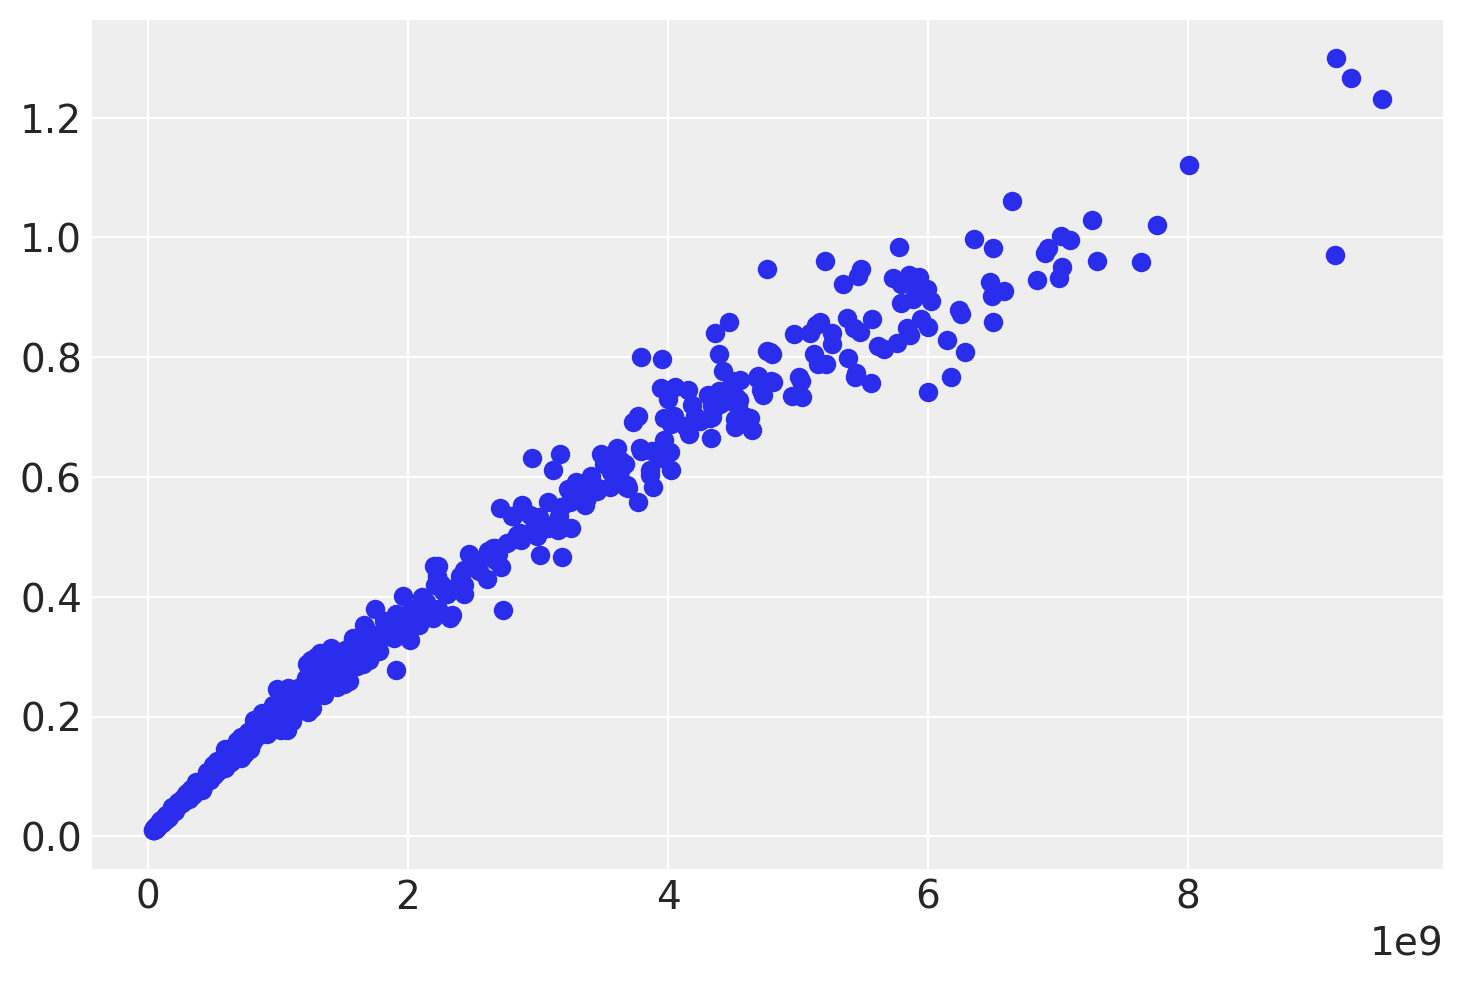

In [10]:
plt.scatter(df['d'], df['zcmb'])

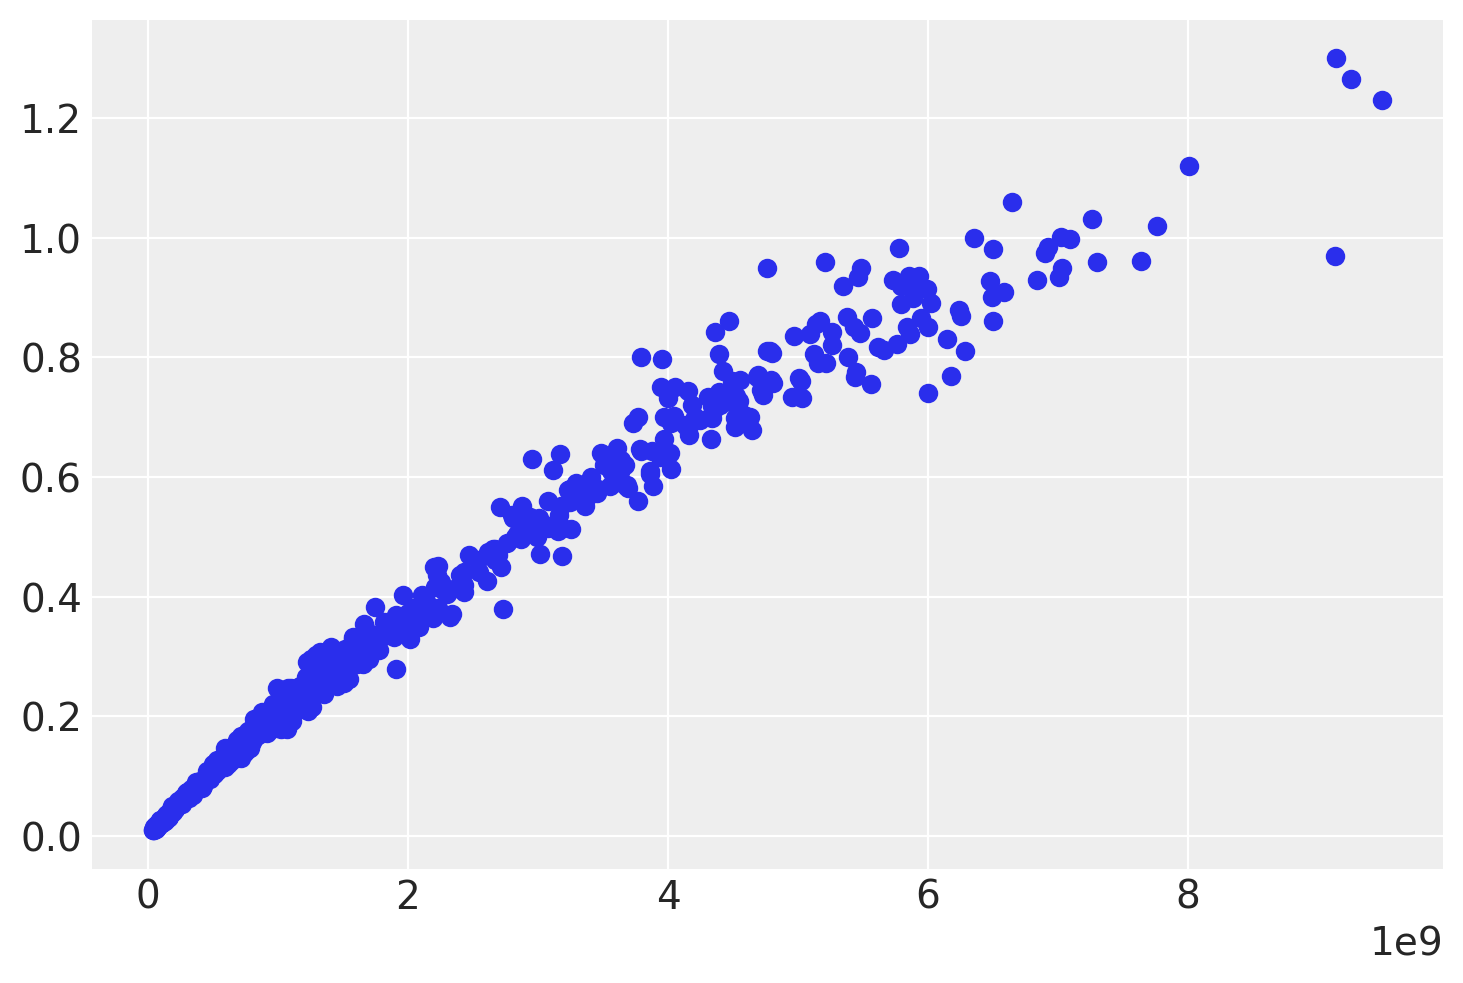

In [11]:
plt.scatter(df['d'], df['zhel'])

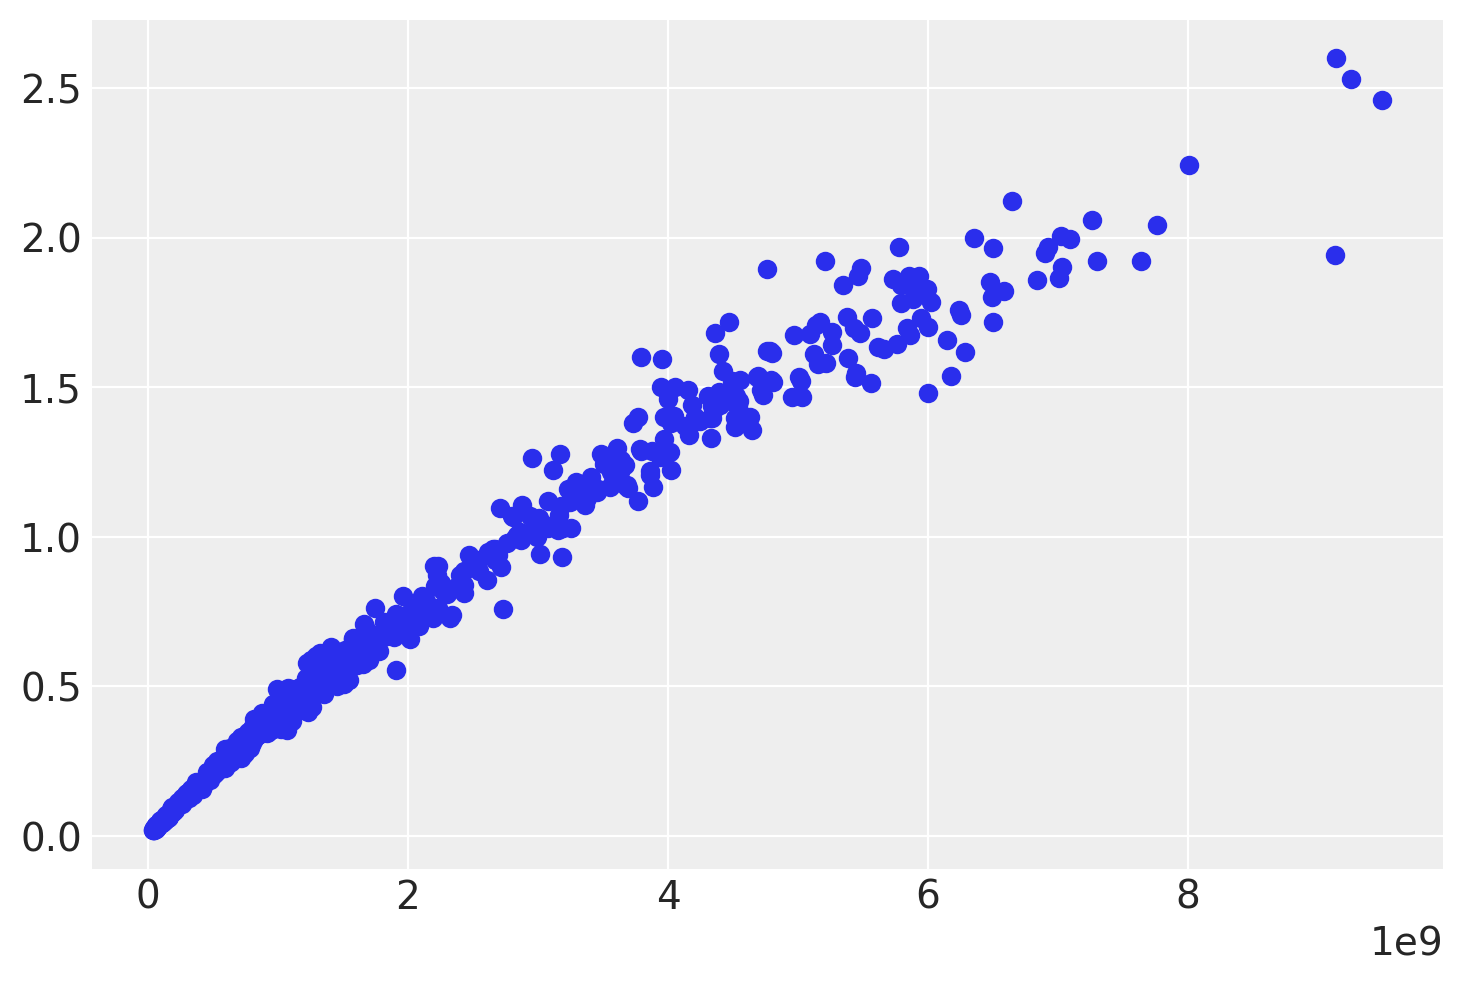

In [12]:
plt.scatter(df['d'], df['zcmb'] + df['zhel'])

In [25]:
reg_1 = stats.linregress(df['zhel'], df['d'])
print(reg_1)

LinregressResult(slope=6671012401.158742, intercept=-283157175.84364533, rvalue=0.9858111664380852, pvalue=0.0, stderr=41813079.61074615, intercept_stderr=17825969.925629634)


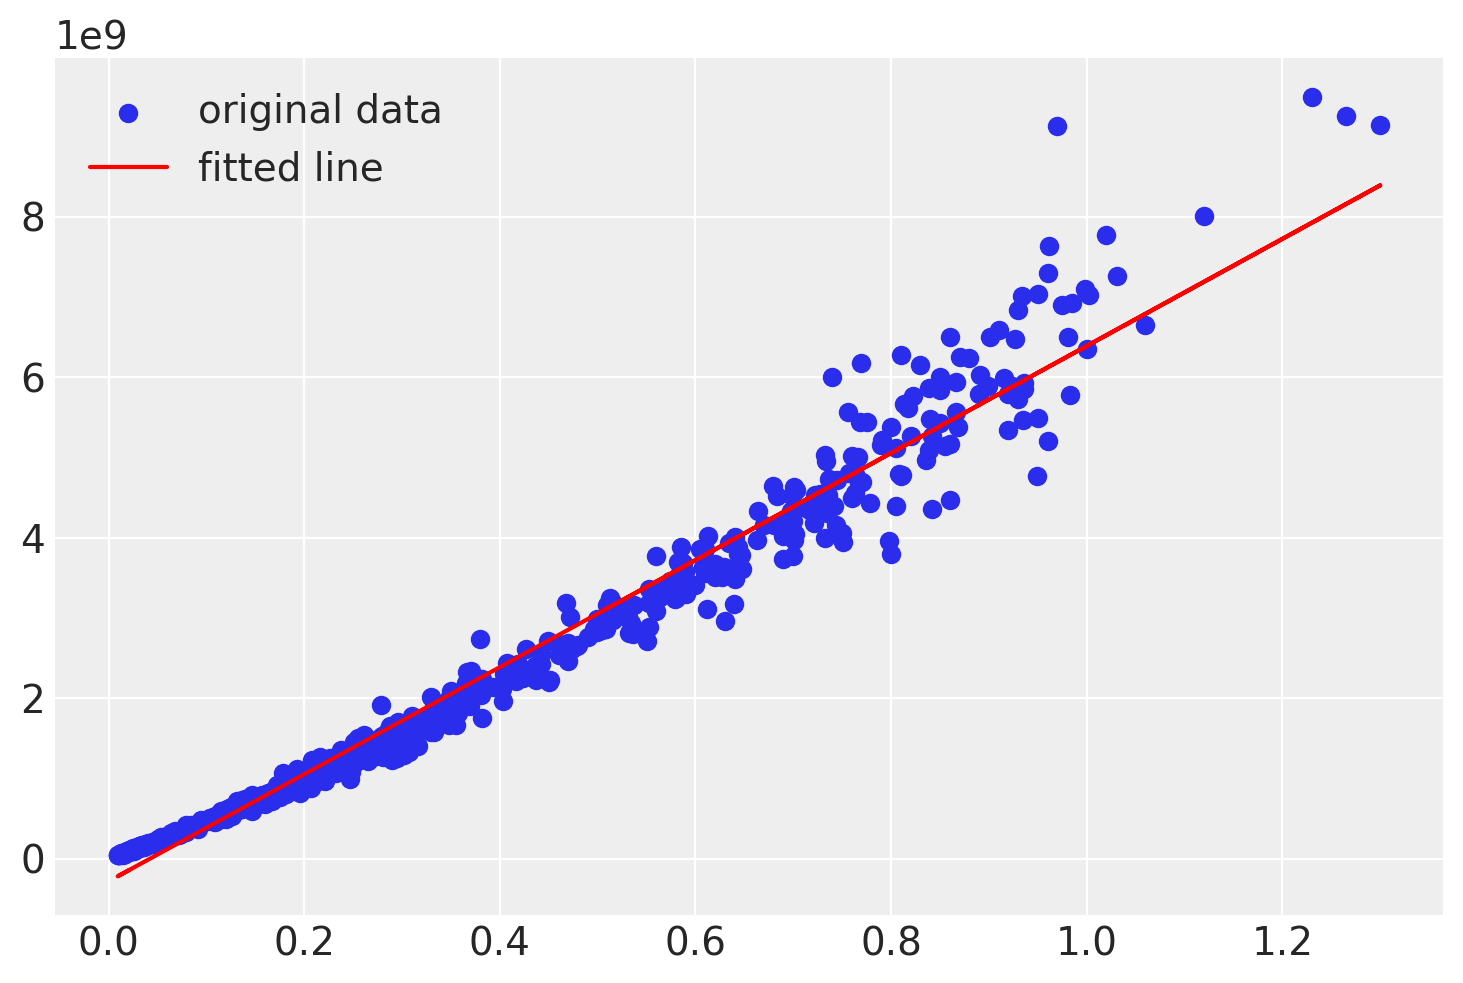

In [31]:
y_pred = reg_1.intercept + (df['zhel'] * reg_1.slope)
residual = y_pred - df['d']

plt.scatter(df['zhel'], df['d'], label='original data')
plt.plot(df['zhel'], y_pred, 'r', label='fitted line')
plt.legend()

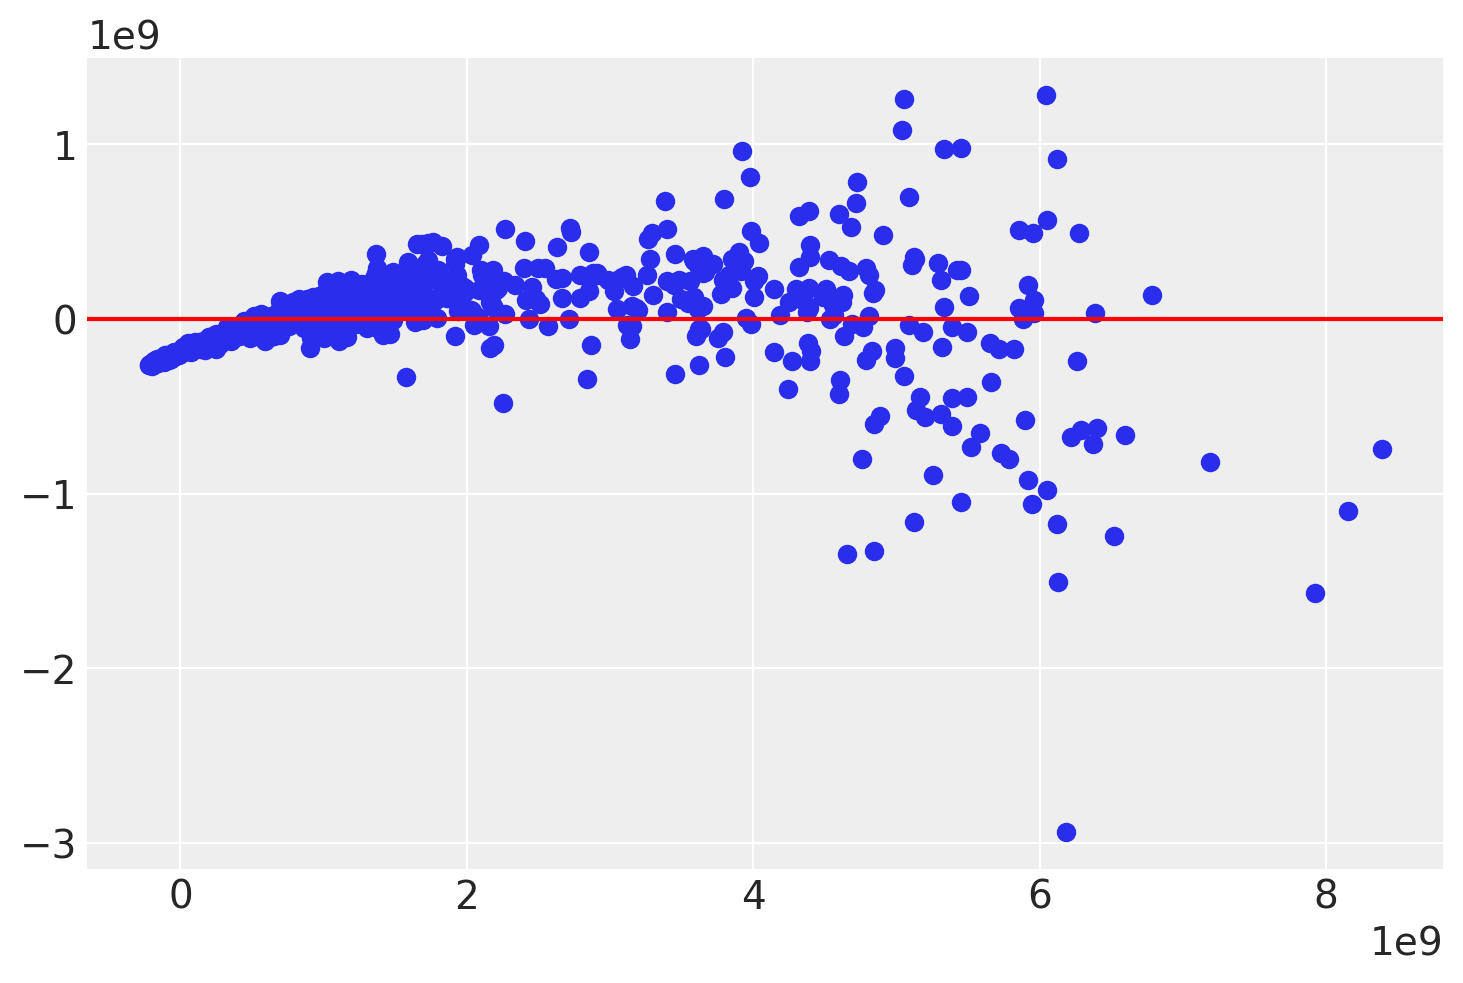

In [39]:
plt.scatter(y_pred, residual)
plt.axhline(y=0, color='r')

In [18]:
with pm.Model() as initial_model:
    x = pm.Data('Zhel', df.zhel, mutable=True)
    y = pm.Data('Distance', df.d, mutable=False)
    beta = pm.Normal('beta', mu=0, tau=1./10, shape=2)
    precision = pm.Gamma('precision', alpha=1, beta=1)
    mu = beta[0] + beta[1]*x
    Y_obs = pm.Normal('Y_obs', mu=mu, tau=precision, observed=y)
    start = pm.find_MAP()
    # draw "draws" posterior samples
    ini_trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000)

<ipython-input-18-8e3b21bcf4af>:14: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  ini_trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [20]:
ini_trace.posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 10000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 1.522 -0.2371 ... -5.535 1.898
    precision   (chain, draw) float64 1.427e-19 1.418e-19 ... 1.432e-19
Attributes:
    created_at:                 2023-11-10T17:25:47.287121
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.7.2
    sampling_time:              79.35820841789246
    tuning_steps:               1000

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'precision'}>]], dtype=object)

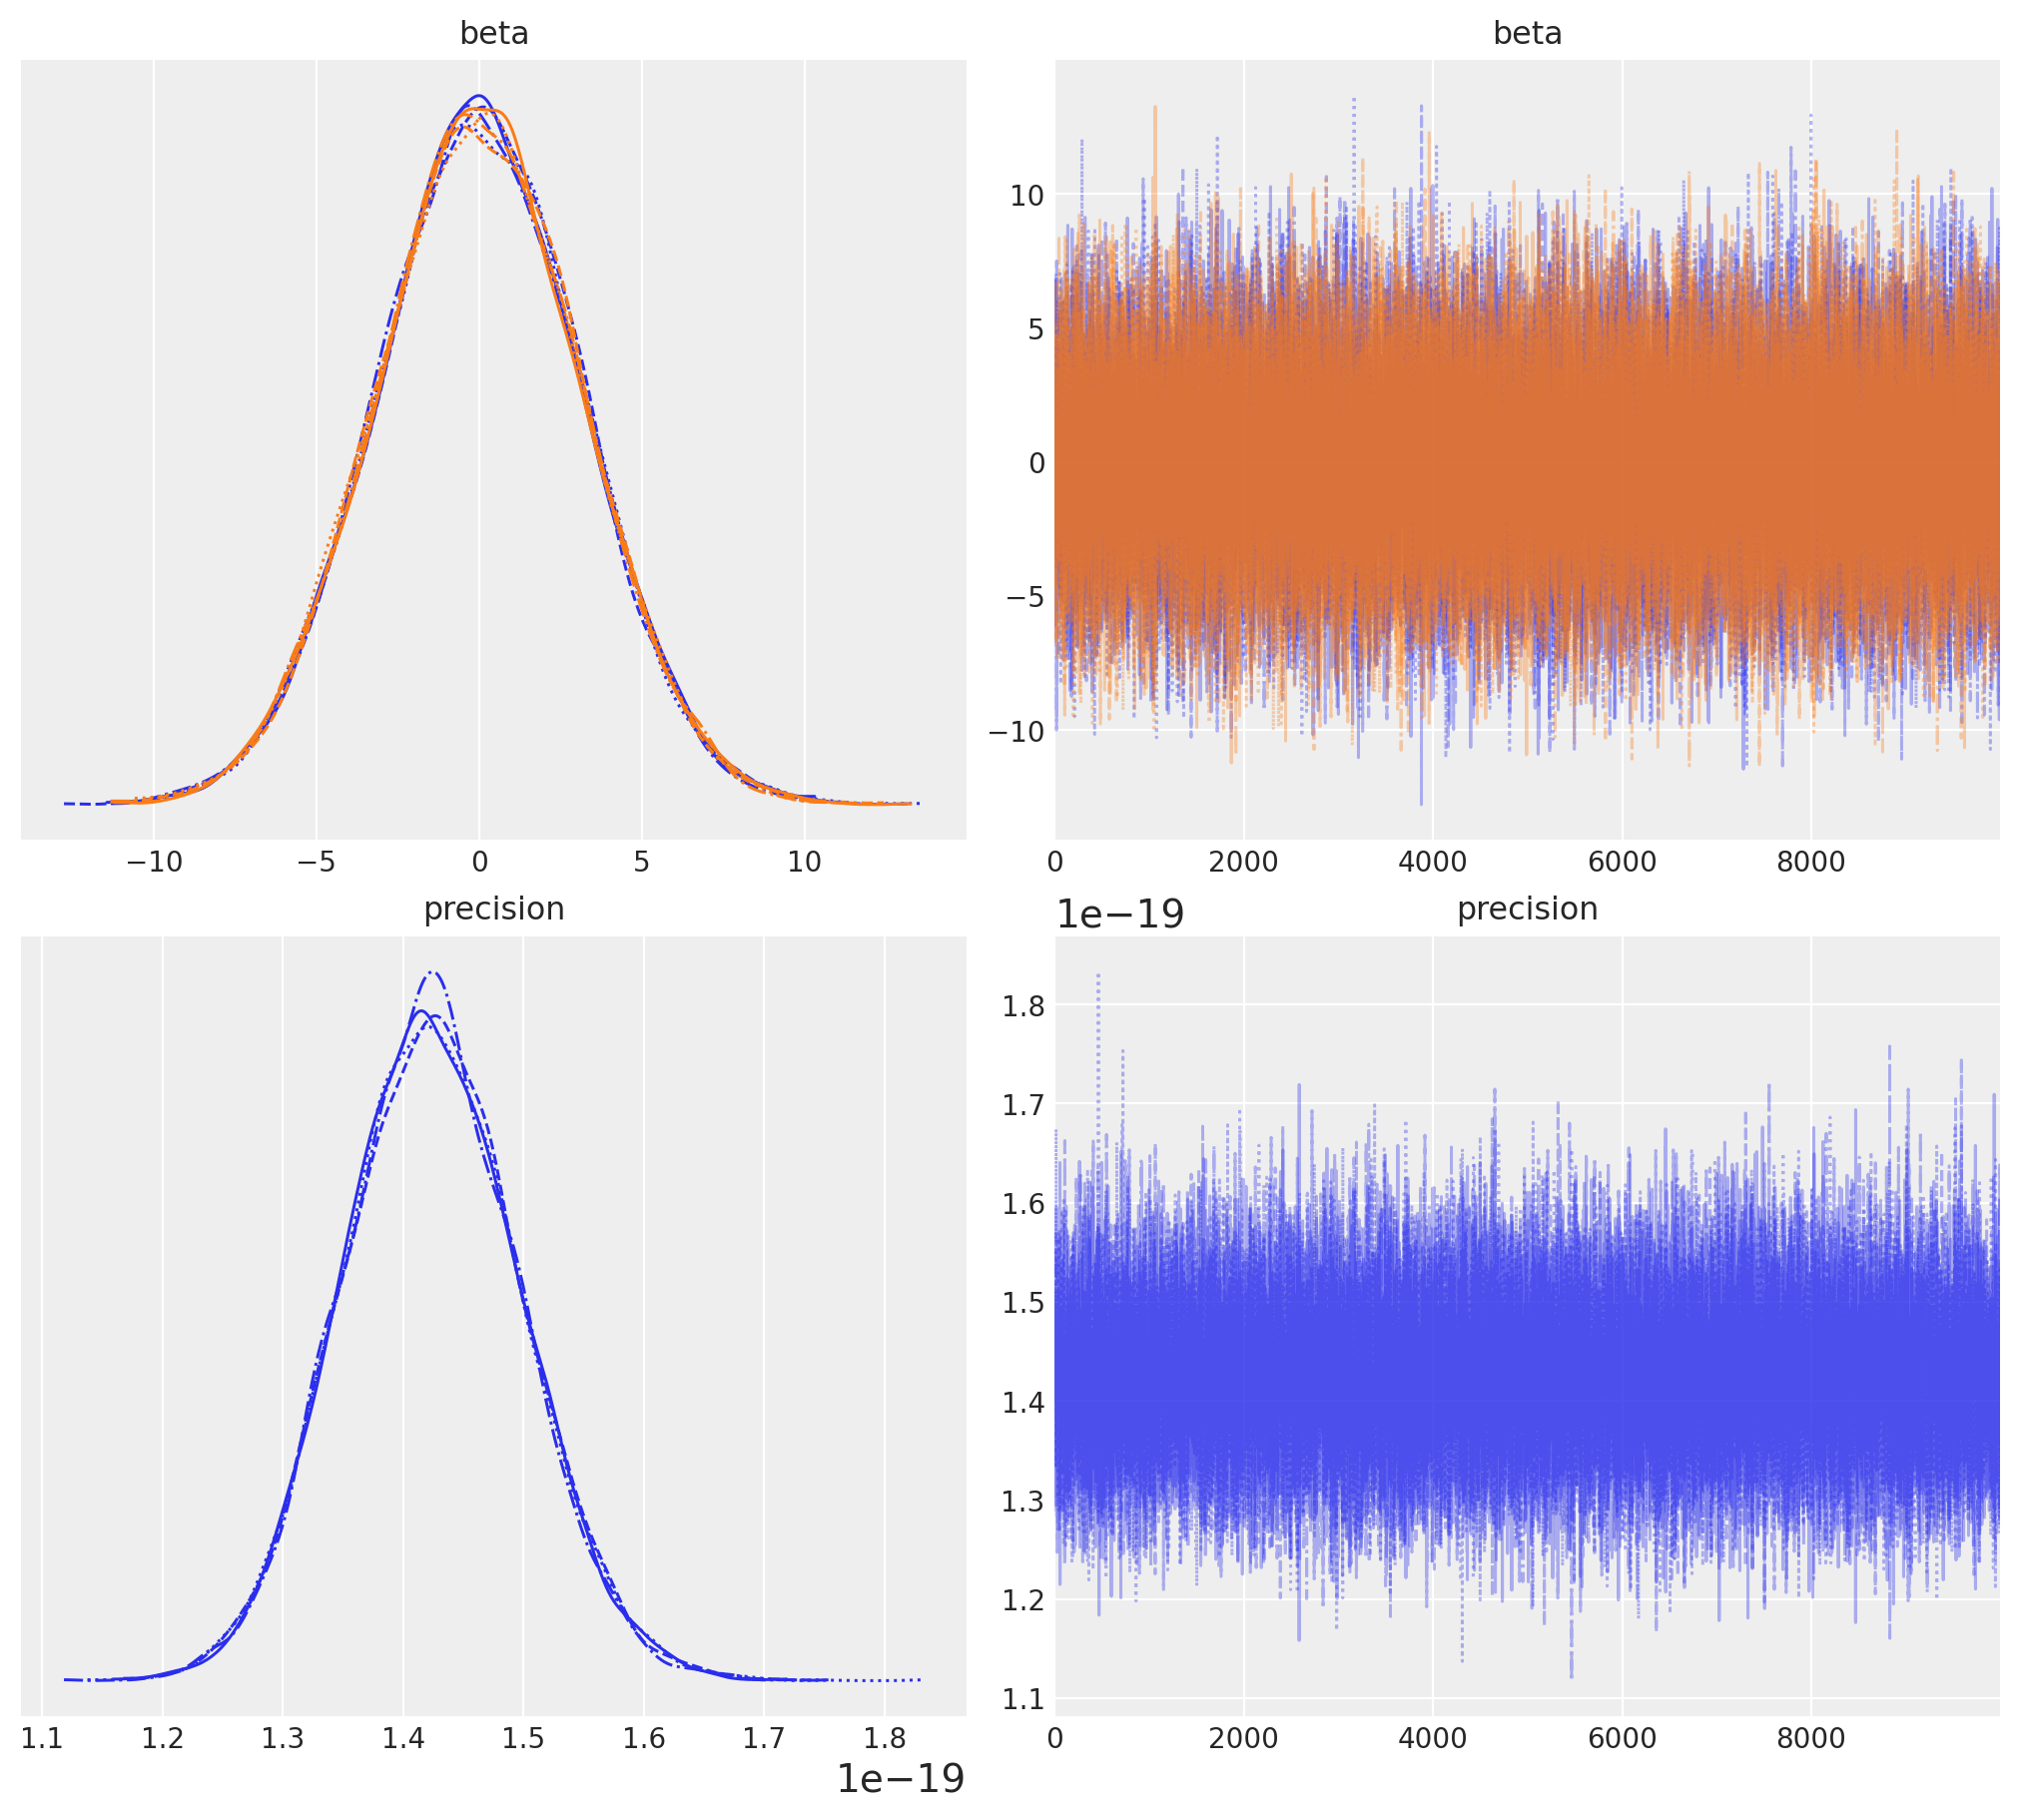

In [24]:
az.plot_trace(ini_trace,figsize=(10, 9))